# NBA Player Shooting Statistics Analysis
## Introduction
The evolution of basketball since its inception has been fascinating and anything fascinating is subject to data analysis. By number of wins, the 2015-16 Golden State Warriors team and 1995-96 Chicago Bulls team had the two greatest seasons for a team. Statistically speaking, the leaders of these teams, Steph Curry and Michael Jordan respectively, had arguably their greatest seasons as a player. Looking into individual shooting statistics from those years, in addition to the 2022-23 season, can provide a piece of insight on how the NBA has changed over the years and if there is any formula for team success. 

This project uses datasets downloaded from the Basketball Reference website:
* [1995-96 Player Stats](https://www.basketball-reference.com/leagues/NBA_1996_totals.html)
* [2015-16 Player Stats](https://www.basketball-reference.com/leagues/NBA_2016_per_game.html)
* [2022-23 Player Stats](https://www.basketball-reference.com/leagues/NBA_2023_totals.html)

<hr style="border: 0.5px solid black">

### Definitions
* <b>Field goal percentage (FG%)</b>: number of made shots out of number attempted shots; a field goal can either be a 2-point shot or a 3-point shot
* <b>2-point percentage(2P%)/3-point percentage (3P%)</b>: number of made 2-point shots / 3-point shots out of number of attempted 2-point shots / 3-point shots
* <b>Free throw percentage (FT%)</b>: number of made free throws out of number attempted free throws (free throws are 1-point shots that a player attempts after being fouled by the other team)
* <b>Effective field goal percentage (eFG%)</b>: an adjusted field goal percentage that factors in 3-point field goals counting for 3 points and 2-point field goals counting for 2 points, i.e. a better way to look at a player's scoring efficiency
* <b>Assists (AST)</b>: when a player passes to another player and that player scores, the original passer receives an assist
* <b>Rebound/Total Rebounds (TRB)</b>: when a player misses a shot (field goal or free throw) and a player grabs the miss, that player is awarded a rebound
* Positions:
    * <b>Point Guard (PG)</b>, <b>Shooting Guard (SG)</b>: typically smaller and quicker; handle the ball more and often score more
    * <b>Small Forward (SF)</b>, <b>Power Forward (PF)</b>, <b>Center (C)</b>: typically taller, primarily are closer to the basket and more likely to shooter 2-point shots, especially the PF an C positions
 
<hr style="border: 0.5px solid black">

### Questions
* Is there a correlation between a player's field goal percentage (FG%) and a player's: 3-point percentage (3P%)? free throw percentage (FT%)? effective field goal percentage (eFG%)?
* How has that correlation changed in each of the three seasons?
* How does Michael Jordan (1994-95), Steph Curry (2015-16), Nikola Jokic (2022-23), and Jalen Green (2022-23) compare to one another in their respective years in each of these statistics? (I included Nikola Jokic because he was the best player on the 2022-23 NBA Champions, Denver Nuggets; I chose Jalen Green because he is my favorite player on my favorite team, the Houston Rockets.)
* Has the number of players per position, number of points per position, number of 3-pointers scored per position changed across these three years?
* Have teams made adjustments to number of 3-pointers attempted based on position?
* How have points, assists, and rebounds changed over the years?
* What other insights about 3-pointers can we gather?

<hr style="border: 0.5px solid black">

## Data Preparation, Cleaning, and Exploratory Analysis

First, I downloaded each .csv from Basketball Reference and imported them as tables into Microsoft SQL Server 2019. I ran some exploratory analysis to see how many zeros were in each table and if the "Player-additional" column could be used as a unique identifier.

<hr style="border: 0.5px solid black">

### SQL
````sql
select count(*)
  from NBA..['1995_96$']

select count(distinct "Player-additional") -- unique player id
  from NBA..['1995_96$']

select round(sum(case when "G" = 0 then 1 else 0 end) * 1.0 / count(*),5)
  from NBA..['1995_96$']

select round(sum(case when "FG" = 0 then 1 else 0 end) * 1.0 / count(*),5)
  from NBA..['1995_96$']

select round(sum(case when "FGA" = 0 then 1 else 0 end) * 1.0 / count(*),5)
  from NBA..['1995_96$']

select round(sum(case when "3P" = 0 then 1 else 0 end) * 1.0 / count(*),5)
  from NBA..['1995_96$']

select round(sum(case when "3PA" = 0 then 1 else 0 end) * 1.0 / count(*),5)
  from NBA..['1995_96$']
````

![image](https://github.com/mraibon/NBAPlayerAnalysis/blob/main/SQLResults/EDAs.png?raw=true)

Next, I checked the columns for any strange results. I noticed that the position ("Pos") column would (rarely) list two positions for the same player. Because I only wanted one position, I had to update my tables using 'update' in SQL. Example from the 1995-96 table below:

````sql
select "Player-additional", "Pos"
  from NBA..['1995_96$']
 where "POS" in ('PF-C', 'SG-SF')
````

![image](https://github.com/mraibon/NBAPlayerAnalysis/blob/main/SQLResults/results%20of%20checking%20players%20with%20mult.%20positions.png?raw=true)

<b>Update</b>:
````sql
update NBA..['1995_96$']
   set "POS" = 'SG'
  where "Player-additional" = 'currymi01'

update NBA..['1995_96$']
   set "POS" = 'PF'
  where "Player-additional" = 'willihe01'
````

Next, I wanted to rank players by FG%. In order to officially qualify for FG%, the NBA sets a minimum of 300 made field goals. A similar minimum for free throws is set at 125 and for 3-pointers at 82. After sorting the data by FG%, I wanted to get each player's position rank for FG%, 2P%, 3P%, eFG%, and FT%. For example, Michael Jordan was ranked 34th in FG%, but for his position (SG, or shooting guard), he was ranked 4th. This required the use of left joins, ranks, and partitions below:

````sql
select nba_stats."Player"
     , nba_stats."Player-additional"
	 , nba_stats."POS"
	 , nba_stats."FG%"
	 , rank() over(partition by "POS" order by "FG%" desc, "FGA" desc) as 'FG_pct_pos_rank'
	 , "2P_pct_pos_rank"
	 , "3P_pct_pos_rank"
	 , "eFG_pct_pos_rank"
	 , "FT_pct_pos_rank"
  from NBA..['1995_96$'] as nba_stats
  left join (
			 select "Player"
				  , "Player-additional"
				  , rank() over(partition by "POS" order by "2P%" desc, "2PA" desc) as '2P_pct_pos_rank'
			   from NBA..['1995_96$'] as two_pt
			  where two_pt."FG" >= 300 ) as two_pt
    on nba_stats."Player-additional" = two_pt."Player-additional"
  left join (
			 select "Player"
			 , "Player-additional"
			 , rank() over(partition by "POS" order by "3P%" desc, "3PA" desc) as '3P_pct_pos_rank'
		  from NBA..['1995_96$']
		 where "3P" >= 82) as three_pt
	on nba_stats."Player-additional" = three_pt."Player-additional"
  left join (
			 select "Player"
			 , "Player-additional"
			 , rank() over(partition by "POS" order by "eFG%" desc, "FGA" desc) as 'eFG_pct_pos_rank'
		  from NBA..['1995_96$']
		 where "FG" >= 300) as eFG
    on nba_stats."Player-additional" = eFG."Player-additional"
  left join (
			 select "Player"
			 , "Player-additional"
			 , rank() over(partition by "POS" order by "FT%" desc, "FTA" desc) as 'FT_pct_pos_rank'
		  from NBA..['1995_96$']
		 where "FT" >= 125) as FT
    on nba_stats."Player-additional" = FT."Player-additional"
 where "FG" >= 300
 order by "FG%" desc
 ````

![image](https://github.com/mraibon/NBAPlayerAnalysis/blob/main/SQLResults/1995-96%20position%20rank%20results.png?raw=true)

In the 1995-96 season, the top players by FG% didn't qualify for the 3P because they didn't make enough 3-pointers. This was typical for players that played the center (C) or power forward (PF) positions at the time. Contrasting that with the 2022-23 season (below), we can see more PF and C qualifying:

![image](https://github.com/mraibon/NBAPlayerAnalysis/blob/main/SQLResults/2022-23%20position%20rank%20results.png?raw=true)

I wanted to see if the number of players per position had changed over the years. I also wanted to see if the average number of games and minutes played in each of these positions had changed. This could show which "era" had players had more "durability".

````sql
select "Pos"
     , count("Pos") as number_of_players
	 , round(avg("G"),2) as avg_games_played
	 , round(avg("MP"),2) as avg_minutes_played
  from NBA..['1995_96$']
 group by "Pos"
 order by
	 case
		 when "POS" = 'PG' then 1
		 when "POS" = 'SG' then 2
		 when "POS" = 'SF' then 3
		 when "POS" = 'PF' then 4
		 when "POS" = 'C' then 5
	  end
````

![image](https://github.com/mraibon/NBAPlayerAnalysis/blob/main/SQLResults/players%20by%20position%20and%20games%20and%20minutes%20played.png?raw=true)

With the increase in players, this had led to a decrease in the number of games and minutes played. This could mean more players are getting opportunities to play throughout the season, whether due to coaches incorporating the entire team or due to more player injuries or rest days. Whatever the reason, considering this in a deeper analysis would be absolutely necessary.

I created age brackets based on the 1995-96 percentiles (SQL below) and wanted to see the number of players, average games played, average minutes played, and average eFG% in each of these age brackets across the years.

````sql
-- percentiles
select min("Age")
  from NBA..['1995_96$']

select top 1 percentile_cont(0.75) within group (order by "Age" desc) over() as percentile_75
  from NBA..['1995_96$']

select avg("Age")
  from NBA..['1995_96$']

 select top 1 percentile_cont(0.25) within group (order by age desc) over() as percentile_25
  from NBA..['1995_96$']

select max("Age")
  from NBA..['1995_96$']

-- creating age brackets in each table
select case 
		   when "Age" between 17 and 24 then '17-24'
		   when "Age" between 25 and 29 then '25-29'
		   when "Age" between 30 and 34 then '30-34'
		   when "Age" > 34 then '35+'
	    end as age_bracket
	  , count("Player-additional") as number_of_players
	  , round(avg("G"),2) as avg_games_played
	  , round(avg("MP"),2) as avg_minutes_played
	  , round(avg("eFG%"),2) as avg_eFG_pct
  from NBA..['1995_96$']
 group by (case 
		   when "Age" between 17 and 24 then '17-24'
		   when "Age" between 25 and 29 then '25-29'
		   when "Age" between 30 and 34 then '30-34'
		   when "Age" > 34 then '35+'
	        end)

select case 
		   when "Age" between 17 and 24 then '17-24'
		   when "Age" between 25 and 29 then '25-29'
		   when "Age" between 30 and 34 then '30-34'
		   when "Age" > 34 then '35+'
	    end as age_bracket
	  , count("Player-additional") as number_of_players
	  , round(avg("G"),2) as avg_games_played
	  , round(avg("MP"),2) as avg_minutes_played
	  , round(avg("eFG%"),2) as avg_eFG_pct
  from NBA..['2015_16$']
 group by (case 
		   when "Age" between 17 and 24 then '17-24'
		   when "Age" between 25 and 29 then '25-29'
		   when "Age" between 30 and 34 then '30-34'
		   when "Age" > 34 then '35+'
	        end)

select case 
		   when "Age" between 17 and 24 then '17-24'
		   when "Age" between 25 and 29 then '25-29'
		   when "Age" between 30 and 34 then '30-34'
		   when "Age" > 34 then '35+'
	    end as age_bracket
	  , count("Player-additional") as number_of_players
	  , round(avg("G"),2) as avg_games_played
	  , round(avg("MP"),2) as avg_minutes_played
	  , round(avg("eFG%"),2) as avg_eFG_pct
  from NBA..['2022_23$']
 group by (case 
		   when "Age" between 17 and 24 then '17-24'
		   when "Age" between 25 and 29 then '25-29'
		   when "Age" between 30 and 34 then '30-34'
		   when "Age" > 34 then '35+'
	        end)
````

<b>Results</b>:
![image](https://github.com/mraibon/NBAPlayerAnalysis/blob/main/SQLResults/age%20brackets.png?raw=true)

We've seen an increase in the number of younger players. In 2005, the NBA required players to go to college for at least one year before jumping into the NBA and yet, there still weren't that many younger players in the NBA in the 1990s. I also expected a dip in the average games and minutes played once players reached 30, but the numbers in the 30-34 range are on par or greater than players in their 20s. It is encouraging that we see an increase in average eFG% - I wonder if this is due to less minutes and games being played and thus, less attempts - or if players are truly just more efficient scorers than in the past.

<hr style="border: 0.5px solid black">

## Data Analysis

Now, I will import these tables into separate dataframes and do more analyses in Python.

In [1]:
import pandas as pd
import seaborn as sns #visualize as we go
import matplotlib.pyplot as plt
from unidecode import unidecode

In [2]:
#diplay all columns
pd.set_option('display.max_columns', 500)

In [3]:
df1 = pd.read_excel(r"C:\Users\micha\OneDrive\Documents\Projects\my_projects\nba_2\datasets\1995_96_player_stats.xlsx")
df1

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,1,Mahmoud Abdul-Rauf,PG,26,DEN,57,53,2029,414,955,0.434,121,309,0.392,293,646,0.454,0.497,146,157,0.930,26,112,138,389,64,3,115,117,1095,abdulma02
1,2,Michael Adams,PG,33,CHH,21,3,329,37,83,0.446,14,41,0.341,23,42,0.548,0.530,26,35,0.743,5,17,22,67,21,4,25,25,114,adamsmi01
2,3,Rafael Addison,SF,31,CHH,53,0,516,77,165,0.467,0,9,0.000,77,156,0.494,0.467,17,22,0.773,25,65,90,30,9,9,27,74,171,addisra01
3,4,Cory Alexander,PG,22,SAS,60,0,560,63,155,0.406,26,66,0.394,37,89,0.416,0.490,16,25,0.640,9,33,42,121,27,2,68,94,168,alexaco01
4,5,Jerome Allen,SG,23,MIN,41,0,362,36,105,0.343,10,33,0.303,26,72,0.361,0.390,26,36,0.722,5,20,25,49,21,5,34,42,108,allenje01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,425,David Wood,PF,31,TOT,62,0,772,75,174,0.431,20,62,0.323,55,112,0.491,0.489,38,50,0.760,51,103,154,34,19,10,24,150,208,woodda01
425,426,Randy Woods,PG,25,DEN,8,0,72,6,22,0.273,5,21,0.238,1,1,1.000,0.386,2,2,1.000,3,3,6,12,6,1,5,13,19,woodsra01
426,427,Haywoode Workman,PG,30,IND,77,4,1164,101,259,0.390,23,71,0.324,78,188,0.415,0.434,54,73,0.740,27,97,124,213,65,4,93,152,279,workmha01
427,428,Sharone Wright,C,23,TOT,57,38,1434,248,512,0.484,1,3,0.333,247,509,0.485,0.485,167,259,0.645,148,208,356,38,30,49,109,163,664,wrighsh01


In [4]:
df2 = pd.read_excel(r"C:\Users\micha\OneDrive\Documents\Projects\my_projects\nba_2\datasets\2015_16_player_stats.xlsx")
df2

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,1,Quincy Acy,PF,25,SAC,59,29,876,119,214,0.556,19,49,0.388,100,165,0.606,0.600,50,68,0.735,65,123,188,27,29,24,27,103,307,acyqu01
1,2,Jordan Adams,SG,21,MEM,2,0,15,2,6,0.333,0,1,0.000,2,5,0.400,0.333,3,5,0.600,0,2,2,3,3,0,2,2,7,adamsjo01
2,3,Steven Adams,C,22,OKC,80,80,2014,261,426,0.613,0,0,NaN,261,426,0.613,0.613,114,196,0.582,219,314,533,62,42,89,84,223,636,adamsst01
3,4,Arron Afflalo,SG,30,NYK,71,57,2371,354,799,0.443,91,238,0.382,263,561,0.469,0.500,110,131,0.840,23,243,266,144,25,10,82,142,909,afflaar01
4,5,Alexis Ajinça,C,27,NOP,59,17,861,150,315,0.476,0,1,0.000,150,314,0.478,0.476,52,62,0.839,75,194,269,31,19,36,54,134,352,ajincal01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,472,Joe Young,PG,23,IND,41,0,384,62,169,0.367,10,46,0.217,52,123,0.423,0.396,20,25,0.800,6,44,50,65,15,0,33,30,154,youngjo01
472,473,Nick Young,SG,30,LAL,54,2,1033,126,372,0.339,77,237,0.325,49,135,0.363,0.442,63,76,0.829,14,83,97,34,23,7,30,50,392,youngni01
473,474,Thaddeus Young,PF,27,BRK,73,73,2407,495,963,0.514,7,30,0.233,488,933,0.523,0.518,105,163,0.644,176,484,660,136,112,37,136,182,1102,youngth01
474,475,Cody Zeller,C,23,CHO,73,60,1774,231,437,0.529,1,10,0.100,230,427,0.539,0.530,175,232,0.754,138,317,455,71,57,63,68,204,638,zelleco01


In [5]:
df3 = pd.read_excel(r"C:\Users\micha\OneDrive\Documents\Projects\my_projects\nba_2\datasets\2022_23_player_stats.xlsx")
df3

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,1,Precious Achiuwa,C,23,TOR,55,12,1140,196,404,0.485,29,108,0.269,167,296,0.564,0.521,87,124,0.702,100,228,328,50,31,30,59,102,508,achiupr01
1,2,Steven Adams,C,29,MEM,42,42,1133,157,263,0.597,0,1,0.000,157,262,0.599,0.597,47,129,0.364,214,271,485,97,36,46,79,98,361,adamsst01
2,3,Bam Adebayo,C,25,MIA,75,75,2598,602,1114,0.540,1,12,0.083,601,1102,0.545,0.541,324,402,0.806,184,504,688,240,88,61,187,208,1529,adebaba01
3,4,Ochai Agbaji,SG,22,UTA,59,22,1209,165,386,0.427,81,228,0.355,84,158,0.532,0.532,56,69,0.812,43,78,121,67,16,15,41,99,467,agbajoc01
4,5,Santi Aldama,PF,22,MEM,77,20,1682,247,525,0.470,94,266,0.353,153,259,0.591,0.560,108,144,0.750,85,286,371,97,45,48,60,143,696,aldamsa01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,535,Thaddeus Young,PF,34,TOR,54,9,795,108,198,0.545,6,34,0.176,102,164,0.622,0.561,18,26,0.692,71,95,166,75,54,5,42,88,240,youngth01
535,536,Trae Young,PG,24,ATL,73,73,2541,597,1390,0.429,154,460,0.335,443,930,0.476,0.485,566,639,0.886,56,161,217,741,80,9,300,104,1914,youngtr01
536,537,Omer Yurtseven,C,24,MIA,9,0,83,16,27,0.593,3,7,0.429,13,20,0.650,0.648,5,6,0.833,8,15,23,2,2,2,4,16,40,yurtsom01
537,538,Cody Zeller,C,30,MIA,15,2,217,37,59,0.627,0,2,0.000,37,57,0.649,0.627,24,35,0.686,25,39,64,10,3,4,14,33,98,zelleco01


When I was running queries in SQL, I noticed some players had an asterisk next to their names, denoting that they were in the NBA Hall of Fame. Because I was running analyses on Michael Jordan, who I know is in the Hall of Fame, I wanted to make searching for him (and any other Hall of Famers) easier by removing the asterisks. 

In [6]:
df1["Player"] = df1["Player"].str.replace('*','')
df2["Player"] = df2["Player"].str.replace('*','')
df3["Player"] = df3["Player"].str.replace('*','')

### Field Goal Percentage Correlation
To see any correlation between FG% and 3P%, FG% and FT%, and FG% and eFG%, I needed to create scatter plots for each and for each of the three NBA seasons. I also wanted to highlight Michael Jordan, Steph Curry, Nikola Jokic, and Jalen Green with their respective team color. In addition to these players, I highlighted their teammates (with the same color) to see if the team as a whole was efficient, and thus contributing to their team's success. As previously mentioned, in order to qualify for FG%, a player must have made at least 300 FGs; however, below, I lowered this minimum to 200 FGs to account for highly efficient 3PT shooters. For example, Steve Kerr only made 244 shots but half of them were 3-pointers - and he was a 52% 3-point shooter!

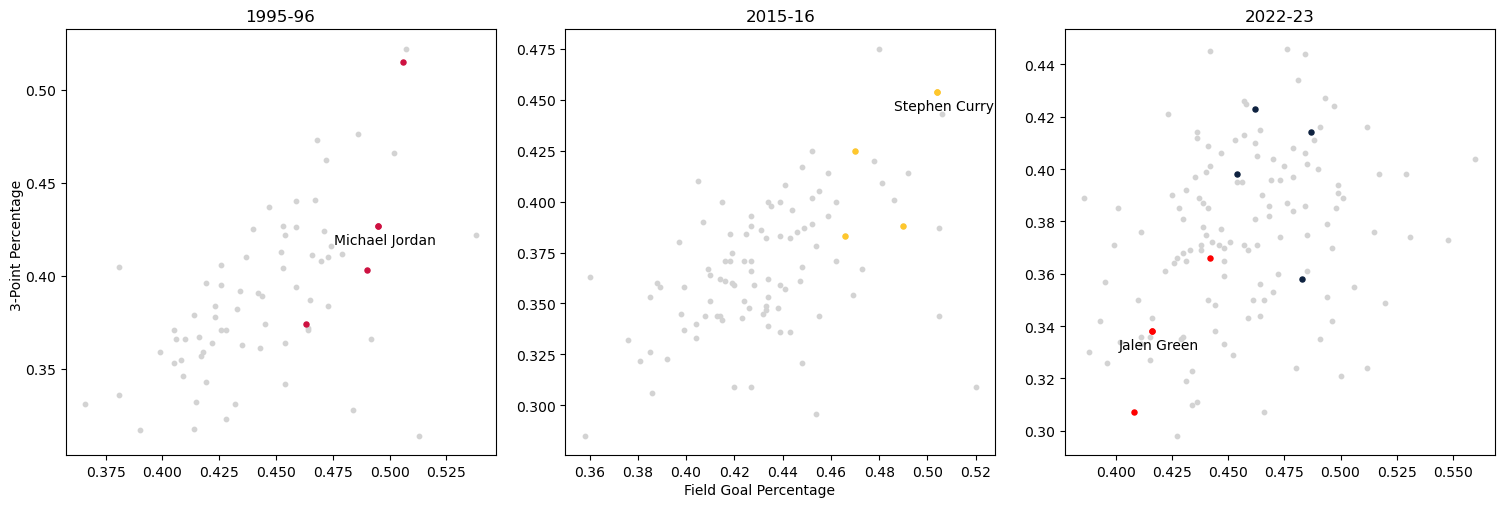

In [7]:
# FG% vs. 3P%

# set minimums
df1_min = df1[(df1['FG'] >= 200) & (df1['3P'] >= 82)]
df2_min = df2[(df2['FG'] >= 200) & (df2['3P'] >= 82)]
df3_min = df3[(df3['FG'] >= 200) & (df3['3P'] >= 82)]

# plotting all 3
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1995-96
# scatterplot
axes[0].scatter(df1_min['FG%'], df1_min['3P%'], s=10, c='lightgray')
axes[0].set_title('1995-96')

# identify Michael Jordan and other Chicago Bulls players in the scatterplot
jordan = df1_min[df1_min['Player'].astype(str) == 'Michael Jordan']
bulls = df1_min[df1_min['Tm'].astype(str) == 'CHI']

# identify Jordan and other Bulls players with color red; label Jordan
axes[0].scatter(jordan['FG%'], jordan['3P%'], s=13, c='#CE1141', label='Michael Jordan')
for idx, row in bulls.iterrows():
    axes[0].scatter(row['FG%'], row['3P%'], s=13, c='#CE1141')

# identify Jordan with label
for idx, row in jordan.iterrows():
    axes[0].annotate(row['Player'], (row['FG%'], row['3P%']),textcoords="offset points", xytext=(5,-13), ha='center')

################################################################################################################################
## 2015-16

# scatterplot
axes[1].scatter(df2_min['FG%'], df2_min['3P%'], s=10, c='lightgray')
axes[1].set_title('2015-16')

# identify Stephen Curry and other Golden State Warriors players in the scatterplot
curry = df2_min[df2_min['Player'].astype(str) == 'Stephen Curry']
warriors = df2_min[df2_min['Tm'].astype(str) == 'GSW']

# identify Curry and other Warriors with color gold
axes[1].scatter(curry['FG%'], curry['3P%'], s=13, c='#FFC72C', label='Stephen Curry')
for idx, row in warriors.iterrows():
    axes[1].scatter(row['FG%'], row['3P%'], s=13, c='#FFC72C')

# identify Curry with label
for idx, row in curry.iterrows():
    axes[1].annotate(row['Player'], (row['FG%'], row['3P%']),textcoords="offset points", xytext=(5,-13), ha='center')

################################################################################################################################
# 2022-23

# scatterplot
axes[2].scatter(df3_min['FG%'], df3_min['3P%'], s=10, c='lightgray')
axes[2].set_title('2022-23')

# identify Jalen Green and other Houston Rockets in the scatterplot
jgreen = df3_min[df3_min['Player'].astype(str) == 'Jalen Green']
rockets = df3_min[df3_min['Tm'].astype(str) == 'HOU']

# identify Nikola Jokić and other Denver Nuggets in the scatterplot
jokic = df3_min[df3_min['Player'].astype(str) == 'Nikola Jokić']
nuggets = df3_min[df3_min['Tm'].astype(str) == 'DEN']

# identify Jalen Green and Nikola Jokić and their teammates
axes[2].scatter(jgreen['FG%'], jgreen['3P%'], s=13, c='red', label='Jalen Green')
for idx, row in rockets.iterrows():
    axes[2].scatter(row['FG%'], row['3P%'], s=13, c='red')
axes[2].scatter(jokic['FG%'], jokic['3P%'], s=13, c='#0E2240', label='Nikola Jokić')
for idx, row in nuggets.iterrows():
    axes[2].scatter(row['FG%'], row['3P%'], s=13, c='#0E2240')

# identify Jalen Green and Nikola Jokić with label
for idx, row in jgreen.iterrows():
    axes[2].annotate(row['Player'], (row['FG%'], row['3P%']),textcoords="offset points", xytext=(5,-13), ha='center')
for idx, row in jokic.iterrows():
    axes[2].annotate(row['Player'], (row['FG%'], row['3P%']),textcoords="offset points", xytext=(5,-13), ha='center')
    
plt.tight_layout()
fig.text(0.5, 0.0001, 'Field Goal Percentage', ha='center')
fig.text(0.0001, 0.5, '3-Point Percentage', va='center', rotation='vertical')
plt.show()

#### 1995-96, 2015-16 Positive Correlation; 2022-23 More Variance
As seen above, both Michael Jordan and Steph Curry, as well as their teammates, were very efficient in respect to their opposition. Steph Curry almost sets himself apart entirely with his efficiency. Unfortunately, Jalen Green didn't do the same but he is still a young player with plenty of potential. Nikola Jokic is missing from this scatter plot because he did not make enough 3-pointers. There is a clear positive correlation in the first two seasons shown; however in the 2022-23 we see much more variance.

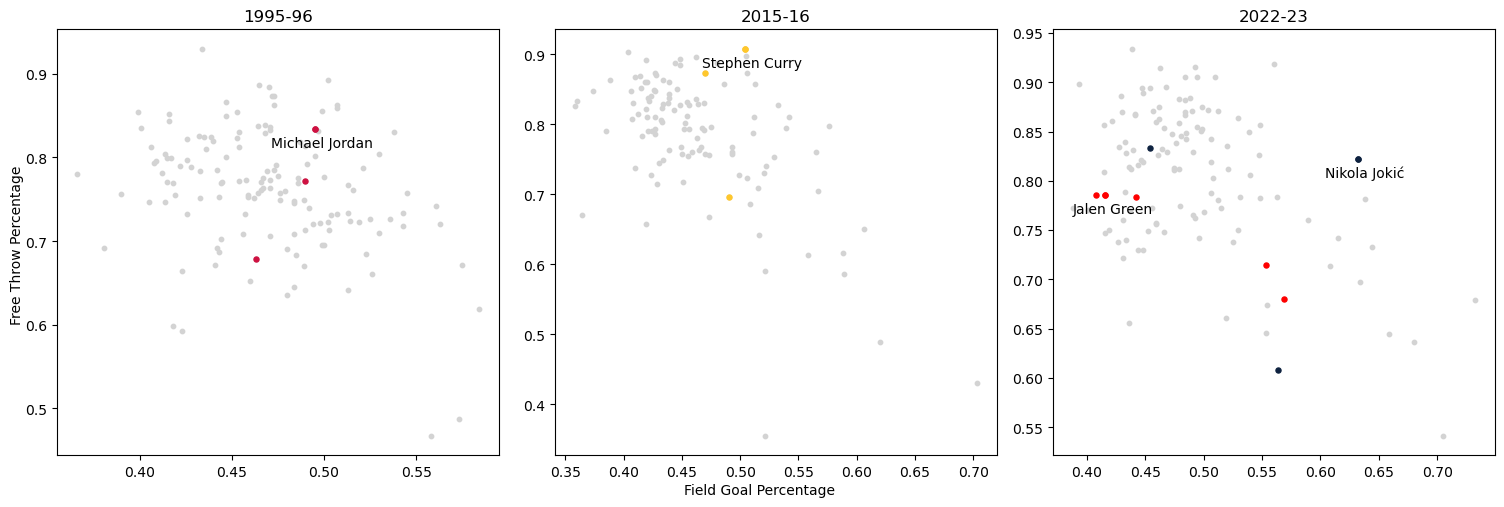

In [10]:
# FG% vs. FT%

# set minimums
df1_min_ft = df1[(df1['FG'] >= 200) & (df1['FT'] >= 125)]
df2_min_ft = df2[(df2['FG'] >= 200) & (df2['FT'] >= 125)]
df3_min_ft = df3[(df3['FG'] >= 200) & (df3['FT'] >= 125)]

# plotting all 3
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1995-96
# scatterplot
axes[0].scatter(df1_min_ft['FG%'], df1_min_ft['FT%'], s=10, c='lightgray')
axes[0].set_title('1995-96')

# identify Michael Jordan and other Chicago Bulls players in the scatterplot
jordan = df1_min_ft[df1_min_ft['Player'].astype(str) == 'Michael Jordan']
bulls = df1_min_ft[df1_min_ft['Tm'].astype(str) == 'CHI']

# identify Jordan and other Bulls players with color red; label Jordan
axes[0].scatter(jordan['FG%'], jordan['FT%'], s=13, c='#CE1141', label='Michael Jordan')
for idx, row in bulls.iterrows():
    axes[0].scatter(row['FG%'], row['FT%'], s=13, c='#CE1141')

# identify Jordan with label
for idx, row in jordan.iterrows():
    axes[0].annotate(row['Player'], (row['FG%'], row['FT%']),textcoords="offset points", xytext=(5,-13), ha='center')

################################################################################################################################
## 2015-16

# scatterlpot
axes[1].scatter(df2_min_ft['FG%'], df2_min_ft['FT%'], s=10, c='lightgray')
axes[1].set_title('2015-16')

# identify Stephen Curry and other Golden State Warriors players in the scatterplot
curry = df2_min_ft[df2_min_ft['Player'].astype(str) == 'Stephen Curry']
warriors = df2_min_ft[df2_min_ft['Tm'].astype(str) == 'GSW']

# identify Curry and other Warriors with color gold
axes[1].scatter(curry['FG%'], curry['FT%'], s=13, c='#FFC72C', label='Stephen Curry')
for idx, row in warriors.iterrows():
    axes[1].scatter(row['FG%'], row['FT%'], s=13, c='#FFC72C')

# identify Curry with label
for idx, row in curry.iterrows():
    axes[1].annotate(row['Player'], (row['FG%'], row['FT%']),textcoords="offset points", xytext=(5,-13), ha='center')

################################################################################################################################
# 2022-23

# scatterplot
axes[2].scatter(df3_min_ft['FG%'], df3_min_ft['FT%'], s=10, c='lightgray')
axes[2].set_title('2022-23')

# identify Jalen Green and other Houston Rockets in the scatterplot
jgreen = df3_min_ft[df3_min_ft['Player'].astype(str) == 'Jalen Green']
rockets = df3_min_ft[df3_min_ft['Tm'].astype(str) == 'HOU']

# identify Nikola Jokić and other Denver Nuggets in the scatterplot
jokic = df3_min_ft[df3_min_ft['Player'].astype(str) == 'Nikola Jokić']
nuggets = df3_min_ft[df3_min_ft['Tm'].astype(str) == 'DEN']

# identify Jalen Green and Nikola Jokić and their teammates
axes[2].scatter(jgreen['FG%'], jgreen['FT%'], s=13, c='red', label='Jalen Green')
for idx, row in rockets.iterrows():
    axes[2].scatter(row['FG%'], row['FT%'], s=13, c='red')
axes[2].scatter(jokic['FG%'], jokic['FT%'], s=13, c='#0E2240', label='Nikola Jokić')
for idx, row in nuggets.iterrows():
    axes[2].scatter(row['FG%'], row['FT%'], s=13, c='#0E2240')

# identify Jalen Green and Nikola Jokić with label
for idx, row in jgreen.iterrows():
    axes[2].annotate(row['Player'], (row['FG%'], row['FT%']),textcoords="offset points", xytext=(5,-13), ha='center')
for idx, row in jokic.iterrows():
    axes[2].annotate(row['Player'], (row['FG%'], row['FT%']),textcoords="offset points", xytext=(5,-13), ha='center')

plt.tight_layout()
fig.text(0.5, 0.0001, 'Field Goal Percentage', ha='center')
fig.text(0.0001, 0.5, 'Free Throw Percentage', va='center', rotation='vertical')
plt.show()

#### 1995-96 Variance; 2015-16, 2022-23 Negative Correlation

There appears to be a negative correlation in our latter seasons, but we can see what makes an efficient FG and FT scorer is someone in the upper mid-to-right quadrant. It is also worth noting that players with high FG% and low FT% are likely centers (think, Shaquille O'neal who was an excellent close-to-the-rim scorer, but struggled at the free throw line). Just because these players struggled with FT% doesn't mean they can't be vital to a team! Nikola Jokic, who is a center, is both efficient at FG% and FT%, which sets him apart from players that are the same position as him.

In [ ]:
# FG% vs. eFG%

# set minimums
df1_min_efg = df1[(df1['FG'] >= 200)]
df2_min_efg = df2[(df2['FG'] >= 200)]
df3_min_efg = df3[(df3['FG'] >= 200)]

# plotting all 3
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1995-96

# scatterplot
axes[0].scatter(df1_min_efg['FG%'], df1_min_efg['eFG%'], s=10, c='lightgray')
axes[0].set_title('1995-96')

# identify Michael Jordan and other Chicago Bulls players in the scatterplot
jordan = df1_min_efg[df1_min_efg['Player'].astype(str) == 'Michael Jordan']
bulls = df1_min_efg[df1_min_efg['Tm'].astype(str) == 'CHI']

# identify Jordan and other Bulls players with color red; label Jordan
axes[0].scatter(jordan['FG%'], jordan['eFG%'], s=13, c='#CE1141', label='Michael Jordan')
for idx, row in bulls.iterrows():
    axes[0].scatter(row['FG%'], row['eFG%'], s=13, c='#CE1141')
    
# identify Jordan with label
for idx, row in jordan.iterrows():
    axes[0].annotate(row['Player'], (row['FG%'], row['eFG%']),textcoords="offset points", xytext=(5,-13), ha='center')

################################################################################################################################
## 2015-16

# scatterplot
axes[1].scatter(df2_min['FG%'], df2_min['eFG%'], s=10, c='lightgray')
axes[1].set_title('2015-16')

# identify Stephen Curry in the scatterplot
curry = df2_min_efg[df2_min_efg['Player'].astype(str) == 'Stephen Curry']
warriors = df2_min_efg[df2_min_efg['Tm'].astype(str) == 'GSW']

# identify Curry and other Warriors with color gold
axes[1].scatter(curry['FG%'], curry['eFG%'], s=13, c='#FFC72C', label='Stephen Curry')
for idx, row in warriors.iterrows():
    axes[1].scatter(row['FG%'], row['eFG%'], s=13, c='#FFC72C')

# identify Curry with label
for idx, row in curry.iterrows():
    axes[1].annotate(row['Player'], (row['FG%'], row['eFG%']),textcoords="offset points", xytext=(5,-13), ha='center')

################################################################################################################################
# 2022-23

# scatterplot
axes[2].scatter(df3_min_efg['FG%'], df3_min_efg['eFG%'], s=10, c='lightgray')
axes[2].set_title('2022-23')

# identify Jalen Green and other Houston Rockets in the scatterplot
jgreen = df3_min_efg[df3_min_efg['Player'].astype(str) == 'Jalen Green']
rockets = df3_min_efg[df3_min_efg['Tm'].astype(str) == 'HOU']

# identify Nikola Jokić and other Denver Nuggets in the scatterplot
jokic = df3_min_efg[df3_min_efg['Player'].astype(str) == 'Nikola Jokić']
nuggets = df3_min_efg[df3_min_efg['Tm'].astype(str) == 'DEN']

# identify Jalen Green and Nikola Jokić and their teammates
axes[2].scatter(jgreen['FG%'], jgreen['eFG%'], s=13, c='red', label='Jalen Green')
for idx, row in rockets.iterrows():
    axes[2].scatter(row['FG%'], row['eFG%'], s=13, c='red')
axes[2].scatter(jokic['FG%'], jokic['eFG%'], s=13, c='#0E2240', label='Nikola Jokić')
for idx, row in nuggets.iterrows():
    axes[2].scatter(row['FG%'], row['eFG%'], s=13, c='#0E2240')

# identify Jalen Green and Nikola Jokić with label
for idx, row in jgreen.iterrows():
    axes[2].annotate(row['Player'], (row['FG%'], row['eFG%']),textcoords="offset points", xytext=(5,-13), ha='center')
for idx, row in jokic.iterrows():
    axes[2].annotate(row['Player'], (row['FG%'], row['eFG%']),textcoords="offset points", xytext=(5,-13), ha='center')

plt.tight_layout()
fig.text(0.5, 0.0001, 'Field Goal Percentage', ha='center')
fig.text(0.0001, 0.5, 'Effective Field Goal Percentage', va='center', rotation='vertical')
plt.show()

#### Strong Positive Correlation

As expected, there is a clear positive correlation between eFG% and FG%. This is because eFG% is just an advanced calculation similar to FG%. Clearly, the best players along this positive line are in the upper right quadrant. Steph Curry, again, sets himself apart. Although Michael Jordan wasn't the highest in this category, he had a teammate who was, which is important to the accomplishments a team can achieve.

Because I suspected that field goal attempts may have decreased over the years, I wanted to plot field goal attempts vs. eFG% to see if there was any correlation.

In [ ]:
# FGA vs. eFG%

## 1995-96

df1_min_efg = df1[(df1['FG'] >= 200)]
df2_min_efg = df2[(df2['FG'] >= 200)]
df3_min_efg = df3[(df3['FG'] >= 200)]

# plotting all 3
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# scatterplot
axes[0].scatter(df1_min_efg['FGA'], df1_min_efg['eFG%'], s=10, c='lightgray')
axes[0].set_title('1995-96')

# identify Michael Jordan and other Chicago Bulls players in the scatterplot
jordan = df1_min_efg[df1_min_efg['Player'].astype(str) == 'Michael Jordan']
bulls = df1_min_efg[df1_min_efg['Tm'].astype(str) == 'CHI']

# identify Jordan and other Bulls players with color red; label Jordan
axes[0].scatter(jordan['FGA'], jordan['eFG%'], s=13, c='#CE1141', label='Michael Jordan')
for idx, row in bulls.iterrows():
    axes[0].scatter(row['FGA'], row['eFG%'], s=13, c='#CE1141')
    
# identify Jordan with label
for idx, row in jordan.iterrows():
    axes[0].annotate(row['Player'], (row['FGA'], row['eFG%']),textcoords="offset points", xytext=(5,-13), ha='center')

################################################################################################################################
## 2015-16

# scatterplot
axes[1].scatter(df2_min['FGA'], df2_min['eFG%'], s=10, c='lightgray')
axes[1].set_title('2015-16')

# identify Stephen Curry in the scatterplot
curry = df2_min_efg[df2_min_efg['Player'].astype(str) == 'Stephen Curry']
warriors = df2_min_efg[df2_min_efg['Tm'].astype(str) == 'GSW']

# identify Curry and other Warriors with color gold
axes[1].scatter(curry['FGA'], curry['eFG%'], s=13, c='#FFC72C', label='Stephen Curry')
for idx, row in warriors.iterrows():
    axes[1].scatter(row['FGA'], row['eFG%'], s=13, c='#FFC72C')

# identify Curry with label
for idx, row in curry.iterrows():
    axes[1].annotate(row['Player'], (row['FGA'], row['eFG%']),textcoords="offset points", xytext=(5,-13), ha='center')

################################################################################################################################
# 2022-23

# scatterplot
axes[2].scatter(df3_min_efg['FGA'], df3_min_efg['eFG%'], s=10, c='lightgray')
axes[2].set_title('2022-23')

# identify Jalen Green and other Houston Rockets in the scatterplot
jgreen = df3_min_efg[df3_min_efg['Player'].astype(str) == 'Jalen Green']
rockets = df3_min_efg[df3_min_efg['Tm'].astype(str) == 'HOU']

# identify Nikola Jokić and other Denver Nuggets in the scatterplot
jokic = df3_min_efg[df3_min_efg['Player'].astype(str) == 'Nikola Jokić']
nuggets = df3_min_efg[df3_min_efg['Tm'].astype(str) == 'DEN']

# identify Jalen Green and Nikola Jokić and their teammates
axes[2].scatter(jgreen['FGA'], jgreen['eFG%'], s=13, c='red', label='Jalen Green')
for idx, row in rockets.iterrows():
    axes[2].scatter(row['FGA'], row['eFG%'], s=13, c='red')
axes[2].scatter(jokic['FGA'], jokic['eFG%'], s=13, c='#0E2240', label='Nikola Jokić')
for idx, row in nuggets.iterrows():
    axes[2].scatter(row['FGA'], row['eFG%'], s=13, c='#0E2240')

# identify Jalen Green and Nikola Jokić with label
for idx, row in jgreen.iterrows():
    axes[2].annotate(row['Player'], (row['FGA'], row['eFG%']),textcoords="offset points", xytext=(5,-13), ha='center')
for idx, row in jokic.iterrows():
    axes[2].annotate(row['Player'], (row['FGA'], row['eFG%']),textcoords="offset points", xytext=(5,-13), ha='center')

plt.tight_layout()
fig.text(0.5, 0.0001, 'Field Goal Attempts', ha='center')
fig.text(0.0001, 0.5, 'Effective Field Goal Percentage', va='center', rotation='vertical')
plt.show()

#### Variance Everywhere

Michael Jordan sets himself apart with purely attempts. The fact he was still as efficient as his peers is excellent. Steph Curry accomplished both! Not only did he have more attempts than many of his peers, but he also scored more efficiently. Nikola Jokic also performed effectively, but had more teammates in the graph than others that could help the team succeed. Jalen Green also had help - the problem is making more opportunity out of the attempts. 

<hr style="border: 0.5px solid black">

### Positions are Changing
In order to see how positions and points per position have changed, I created pie charts to show this change over time.

In [ ]:
# 1995-96
# pie chart for each position

df1_group = df1.groupby('Pos').agg({'Player': 'count', 'PTS': 'sum', '3P': 'sum'})
df1_group.columns = ['Player Count', 'Total Points', '3PT']

custom_order = ['C', 'PF', 'SF', 'SG', 'PG']
custom_colors = ['cornflowerblue', 'khaki', 'plum', 'mediumseagreen', 'lightcoral']
explode1 = [0.03,0.1,0.03,0.03,0.03]
explode2 = [0.03,0.03,0.1,0.03,0.03]
explode3 = [0.03,0.03,0.03,0.03,0.1]

# Reindex DataFrame according to custom order
df1_group = df1_group.reindex(custom_order)

fig, axes = plt.subplots(1, 3, figsize=(12, 6))

# first pie chart
df1_group['Player Count'].plot(kind='pie', ax=axes[0], autopct='%1.1f%%', startangle=100, colors=custom_colors, explode=explode1, shadow=True, ylabel='')
axes[0].set_title('Players by Position')

# second pie chart 
df1_group['Total Points'].plot(kind='pie', ax=axes[1], autopct='%1.1f%%', startangle=100, colors=custom_colors, explode=explode2, shadow=True, ylabel='')
axes[1].set_title('Points by Position')

# third pie chart
df1_group['3PT'].plot(kind='pie', ax=axes[2], autopct='%1.1f%%', startangle=100, colors=custom_colors, explode=explode3, shadow=True, ylabel='')
axes[2].set_title('3 Pointers Made by Position')

fig.text(0.5, 0.8, '1995-96 NBA Season', ha='center', size=15)
plt.show()

In [ ]:
# 2015-16
# pie chart for each position

df2_group = df2.groupby('Pos').agg({'Player': 'count', 'PTS': 'sum', '3P': 'sum'})
df2_group.columns = ['Player Count', 'Total Points', '3PT']

custom_order = ['C', 'PF', 'SF', 'SG', 'PG']
custom_colors = ['cornflowerblue', 'khaki', 'plum', 'mediumseagreen', 'lightcoral']
explode1 = [0.03,0.1,0.03,0,0.03]
explode2 = [0.03,0.03,0.03,0.1,0.03]
explode3 = [0.03,0.03,0.03,0.1,0.03]

# Reindex DataFrame according to custom order
df2_group = df2_group.reindex(custom_order)

fig, axes = plt.subplots(1, 3, figsize=(12, 6))

# first pie chart
df2_group['Player Count'].plot(kind='pie', ax=axes[0], autopct='%1.1f%%', startangle=100, colors=custom_colors, explode=explode1, shadow=True, ylabel='')
axes[0].set_title('Players by Position')

# second pie chart 
df2_group['Total Points'].plot(kind='pie', ax=axes[1], autopct='%1.1f%%', startangle=100, colors=custom_colors, explode=explode2, shadow=True, ylabel='')
axes[1].set_title('Points by Position')

# third pie chart
df2_group['3PT'].plot(kind='pie', ax=axes[2], autopct='%1.1f%%', startangle=100, colors=custom_colors, explode=explode3, shadow=True, ylabel='')
axes[2].set_title('3 Pointers Made by Position')

fig.text(0.5, 0.8, '2015-16 NBA Season', ha='center', size=15)
plt.show()

In [ ]:
# 2022-23
# pie chart for each position

df3_group = df3.groupby('Pos').agg({'Player': 'count', 'PTS': 'sum', '3P': 'sum'})
df3_group.columns = ['Player Count', 'Total Points', '3PT']

custom_order = ['C', 'PF', 'SF', 'SG', 'PG']
custom_colors = ['cornflowerblue', 'khaki', 'plum', 'mediumseagreen', 'lightcoral']
explode1 = [0.03,0.03,0.03,0.1,0.03]
explode2 = [0.03,0.03,0.03,0.1,0.03]
explode3 = [0.03,0.03,0.03,0.1,0.03]

# Reindex DataFrame according to custom order
df3_group = df3_group.reindex(custom_order)

fig, axes = plt.subplots(1, 3, figsize=(12, 6))

# first pie chart
df3_group['Player Count'].plot(kind='pie', ax=axes[0], autopct='%1.1f%%', startangle=100, colors=custom_colors, explode=explode1, shadow=True, ylabel='')
axes[0].set_title('Players by Position')

# second pie chart 
df3_group['Total Points'].plot(kind='pie', ax=axes[1], autopct='%1.1f%%', startangle=100, colors=custom_colors, explode=explode2, shadow=True, ylabel='')
axes[1].set_title('Points by Position')

# third pie chart
df3_group['3PT'].plot(kind='pie', ax=axes[2], autopct='%1.1f%%', startangle=100, colors=custom_colors, explode=explode3, shadow=True, ylabel='')
axes[2].set_title('3 Points by Position')

fig.text(0.5, 0.8, '2022-23 NBA Season', ha='center', size=15)
plt.show()

There weren't huge shifts in the players per position. What stands out the most is that we're seeing a more even distribution of points amongst all positions. Players that are at the center position are not only scoring more - they're scoring more 3-pointers. Shooting guard still take up the largest chunk of 3-point shooters, but we're seeing larger shifts in centers and power forwards actively make more 3-pointers and point guards taking up less of a share. This would suggest the NBA is shifting to point guards that aren't necessarily great shooters (at least from the 3-point line) and shifting to "shooting bigs" (center or power forwards that shoot).

Next, I wanted to see a heat map showing 3-pointers per team that were made by the positions that shifted the most: point guards, power forwards, and centers. 

In [ ]:
 # these were the positions that changed the most in 3PT shooting
positions = ['PG', 'PF', 'C']

df1_c = df1[(df1['Tm'] != 'TOT') & (df1['Pos'].isin(positions))]
df2_c = df2[(df2['Tm'] != 'TOT') & (df2['Pos'].isin(positions))]
df3_c = df3[(df3['Tm'] != 'TOT') & (df3['Pos'].isin(positions))]

In [ ]:
df1_pivot = df1_c.pivot_table(index='Tm', columns='Pos', values='3P', aggfunc='sum', fill_value=0)
df2_pivot = df2_c.pivot_table(index='Tm', columns='Pos', values='3P', aggfunc='sum', fill_value=0)
df3_pivot = df3_c.pivot_table(index='Tm', columns='Pos', values='3P', aggfunc='sum', fill_value=0)

In [ ]:
# when reading, be careful because teams have changed
fig, axes = plt.subplots(1, 3, figsize=(25,10))

cmap = sns.diverging_palette(10, 250, as_cmap=True)

sns.heatmap(df1_pivot, ax=axes[0], linewidths=0.6, linecolor='white', cmap=cmap)
sns.heatmap(df2_pivot, ax=axes[1], linewidths=0.6, linecolor='white', cmap=cmap)
sns.heatmap(df3_pivot, ax=axes[2], linewidths=0.6, linecolor='white', cmap=cmap)

axes[0].set_title('1995-96')
axes[1].set_title('2015-16')
axes[2].set_title('2022-23')



plt.show()

This shift highlighted in the pie charts can also be seen on a per-team basis. Where some teams in the past may have had a point guard shooting 3's and a center/power forward not shooting 3's at all - now, they're doing it more often.

<hr style="border: 0.5px solid black">

### NBA Stats are Increasing!
Since we're seeing these movements in data, I decided to concatenate my dataframes into one (adding a column for the respective season to each) and analyze how points, assists, and rebounds have changed over the years.

In [ ]:
# add the season of the NBA in order to merge
df1['nba_season'] = '1995-96'
df2['nba_season'] = '2015-16'
df3['nba_season'] = '2022-23'

In [ ]:
# combine the three then show total pts (3 years), total asts (3 years), total rebs (3 years) -- bar chart
df_combo = pd.concat([df1,df2,df3])

In [ ]:
df_combo_grp_pts = df_combo.groupby('nba_season').agg({'PTS': 'sum'})

In [ ]:
df_combo_grp_pts

In [ ]:
df_combo_grp = df_combo.groupby('nba_season').agg({'FT': 'sum', '2P': 'sum', '3P': 'sum', 'AST': 'sum', 'TRB': 'sum'})

In [ ]:
df_combo_grp

In [ ]:
df_combo_grp_pts.plot(kind='bar',title='Total Points by Year',xlabel='Year',ylabel='Total',figsize=(10,6))
plt.xticks(rotation=0)
plt.show()

In [ ]:
# change color
# move legend?
# make PTS one and then everything else one
# chnange size
# restores default: plt.rcParams.update(plt.rcParamsDefault)
df_combo_grp.plot(kind='bar',title='Free Throws, Two Points, 3 Points, Assists, and Rebounds by Year',xlabel='Year',ylabel='Total',figsize=(10,6),color=['cornflowerblue', 'khaki', 'plum', 'mediumseagreen', 'lightcoral'])
plt.xticks(rotation=0)

plt.show()

As expected, every statistics increased. Points would obviously increase based on what we've seen and as another confirmation, 3-points increased. To see how much they've increased, I performed a percentage difference and created a box plot to see variations.

In [ ]:
df_combo_grp

In [ ]:
df_combo_grp_t = df_combo_grp.transpose()
df_combo_grp_t

In [ ]:
# calculating percentage differences between years
df_combo_grp_t['95-96 vs. 15-16'] = df_combo_grp_t[['1995-96', '2015-16']].pct_change(axis=1)['2015-16']
df_combo_grp_t['15-16 vs. 22-23'] = df_combo_grp_t[['2015-16', '2022-23']].pct_change(axis=1)['2022-23']
df_combo_grp_t['95-96 vs. 22-23'] = df_combo_grp_t[['1995-96', '2022-23']].pct_change(axis=1)['2022-23']

In [ ]:
df_combo_grp_t

Nearly 50% increase between each year for 3-pointers and a 116% increae from 1995-96 to 2022-23!

In [ ]:
df_combo_grp.boxplot(column=['budget','revenue'], figsize=(20,10))

In [ ]:
# plotting all 3
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# scatterplot
axes[0].boxplot(df1['3P'])
axes[0].set_title('1995-96')
axes[1].boxplot(df2['3P'])
axes[1].set_title('2015-16')

axes[2].boxplot(df3['3P'])
axes[2].set_title('2022-23')

plt.show()




So interesting to see what used to be an outlier in the 90s is now "normalized" in 2022-23.

Lastly, I wanted to individualize the 3-point shot to see what percentage of total points were 3-pointers for each player. 

In [ ]:
# FG% vs. eFG%

## 1995-96

# plotting all 3
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# scatterplot
axes[0].scatter(df1['PTS'], df1['3P']*3/df1['PTS'], s=10, c='blue')
axes[0].set_title('1995-96')

################################################################################################################################
## 2015-16

axes[1].scatter(df2['PTS'], df2['3P']*3/df2['PTS'], s=10, c='blue')
axes[1].set_title('2015-16')

################################################################################################################################
# 2022-23

# scatterplot
axes[2].scatter(df3['PTS'], df3['3P']*3/df3['PTS'], s=10, c='blue')
axes[2].set_title('2022-23')

fig.text(0.5, 0.01, 'Points Scored', ha='center')
fig.text(0.1, 0.5, '3PT% of PTS Scored', va='center', rotation='vertical')
plt.show()

For a player that has 1.0 on 3pt% and 0 on the points scored, it means their only points were 3-pointers.
The trend is that more percentage of points can be contributed to the 3-pointers.

<hr style="border: 0.5px solid black">

## Conclusion

* <b> Is there a correlation between a player's field goal percentage (FG%) and a player's: 3-point percentage (3P%)? free throw percentage (FT%)? effective field goal percentage (eFG%)? How has that correlation changed in each of the three seasons? </b>
> The correlation has changed over time as evident that we saw positive correlations between FG% and 3P% in the 1995-96 and 2015-16 seasons, but more variance in the 2022-23 season. This suggests the game is indeed evolving in terms of individual efficiency. 

* <b> How does Michael Jordan (1994-95), Steph Curry (2015-16), Nikola Jokic (2022-23), and Jalen Green (2022-23) compare to one another in their respective years in each of these statistics? </b>
> Steph Curry had the greatest season when comparing these stats alone. He stands out amongst his peers much more than the other players, proving his shooting efficiency is rare and phenomenal. However, Steph Curry's team did not win the NBA championship that year so Michael Jordan and Nikola Jokic, along with their teammates, also had very efficient seasons which tells us that basketball is indeed a team sport.

* <b> Has the number of players per position, number of points per position, number of 3-pointers scored per position changed across these three years? </b>
> Yes! We saw drastic changes in how the center and power forward position have contributed more 3-pointers. 

* <b> Have teams made adjustments to number of 3-pointers attempted based on position? </b>
> As evident by the heat map, most teams have adopted the "shooting big" mentality.

* <b> How have points, assists, and rebounds changed over the years? </b>
> All have increased, with 3-pointers seeing the most increase. 

* <b> What other insights about 3-pointers can we gather? </b>
> Players are shooting more 3-pointers and more points for a team can be contributed to the 3-point shot. Is the solution to this to make a 4-point shot? Or making the 3-point line further back? Or is the NBA and its fans okay with how the NBA has changed? 

<hr style="border: 0.5px solid black">